## Exploring Mechanism of Action with Knowledge Graph
### With All Biological Node Types as Intermediary Nodes
- Example with Ondansetron and BPD
- This code is scaled to all possible medications and disease pairs under `Interactive_Webapp` folder

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import matplotlib.patches as mpatches

import pickle

from MOA_functions import *

In [2]:
# node color assigned per node type
node_color_dict= node_color_info()

node_color_df = pd.DataFrame(node_color_dict)
node_color_df


,node_type,color
0,gene/protein,#16AEEF
1,drug,#946BE1
2,effect/phenotype,#41afaa
3,disease,#5DC264
4,biological_process,#FF781E
5,molecular_function,#FF9F21
6,cellular_component,#F9CF57
7,exposure,#466eb4
8,pathway,#00a0e1
9,anatomy,#e6a532


In [3]:
kg = pd.read_parquet('../Interactive_Webapp/2024_reference_tables/kg.parquet')

In [4]:
# Select the nodes of interest for testing
dz_name = 'BPD_OLD_Baby'
med_name = 'Ondansetron, Oral'
dz_id_list = ['19091']
med_id = 'DB00904'

In [5]:
# Select biological nodes as the intermediary nodes
sel_relation = ['protein_protein', 'bioprocess_protein', 'molfunc_protein', 'cellcomp_protein', 
            'bioprocess_bioprocess', 'molfunc_molfunc', 'cellcomp_cellcomp']
sel_kg = kg[kg['relation'].isin(sel_relation)]

# Select the disease of interest and its connection to proteins
disease_kg = kg[(kg['relation'] == 'disease_protein') & (kg['x_id'].isin(dz_id_list))]
disease_kg_y = kg[(kg['relation'] == 'disease_protein') & (kg['y_id'].isin(dz_id_list))]

# Select the drug of interest and its connection to proteins
drug_kg = kg[(kg['relation'] == 'drug_protein') & (kg['x_id'] == med_id)]
drug_kg_y = kg[(kg['relation'] == 'drug_protein') & (kg['y_id'] == med_id)]

final_kg = pd.concat([sel_kg, disease_kg, disease_kg_y, drug_kg, drug_kg_y])

In [6]:
# generate the node and edge list for the networkx graph
kg_node = final_kg.drop(columns=['relation','display_relation'],axis=1)

x_nodes = [i for i in kg_node.columns if i.__contains__('x_')]
y_nodes = [i for i in kg_node.columns if i.__contains__('y_')]

x_nodes_new = {}
for i in x_nodes:
    new_name = 'node'+i[1:]
    x_nodes_new[i]=new_name

y_nodes_new = {}
for i in y_nodes:
    new_name = 'node'+i[1:]
    y_nodes_new[i]=new_name

kg_node_x = kg_node[x_nodes].rename(columns=x_nodes_new)
kg_node_y = kg_node[y_nodes].rename(columns=y_nodes_new)
kg_node_merge = pd.concat([kg_node_x,kg_node_y]).drop_duplicates()
kg_node_merge = pd.merge(kg_node_merge,node_color_df,on='node_type',how='left')
kg_node_merge = kg_node_merge.reset_index().drop(columns=['index'],axis=1)

node_dict = kg_node_merge.to_dict(orient='index')
node_dict
node_list = []
for key in node_dict.keys():
    each_node=(node_dict[key]['node_id'],
    {'node_name':node_dict[key]['node_name'],'node_type':node_dict[key]['node_type'],
    'node_color':node_dict[key]['color']}) #'node_source':node_dict[key]['node_source'],
    node_list.append(each_node)
    
edge_list = make_edge_list(final_kg)

In [7]:
### Construct a Graph! ###
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

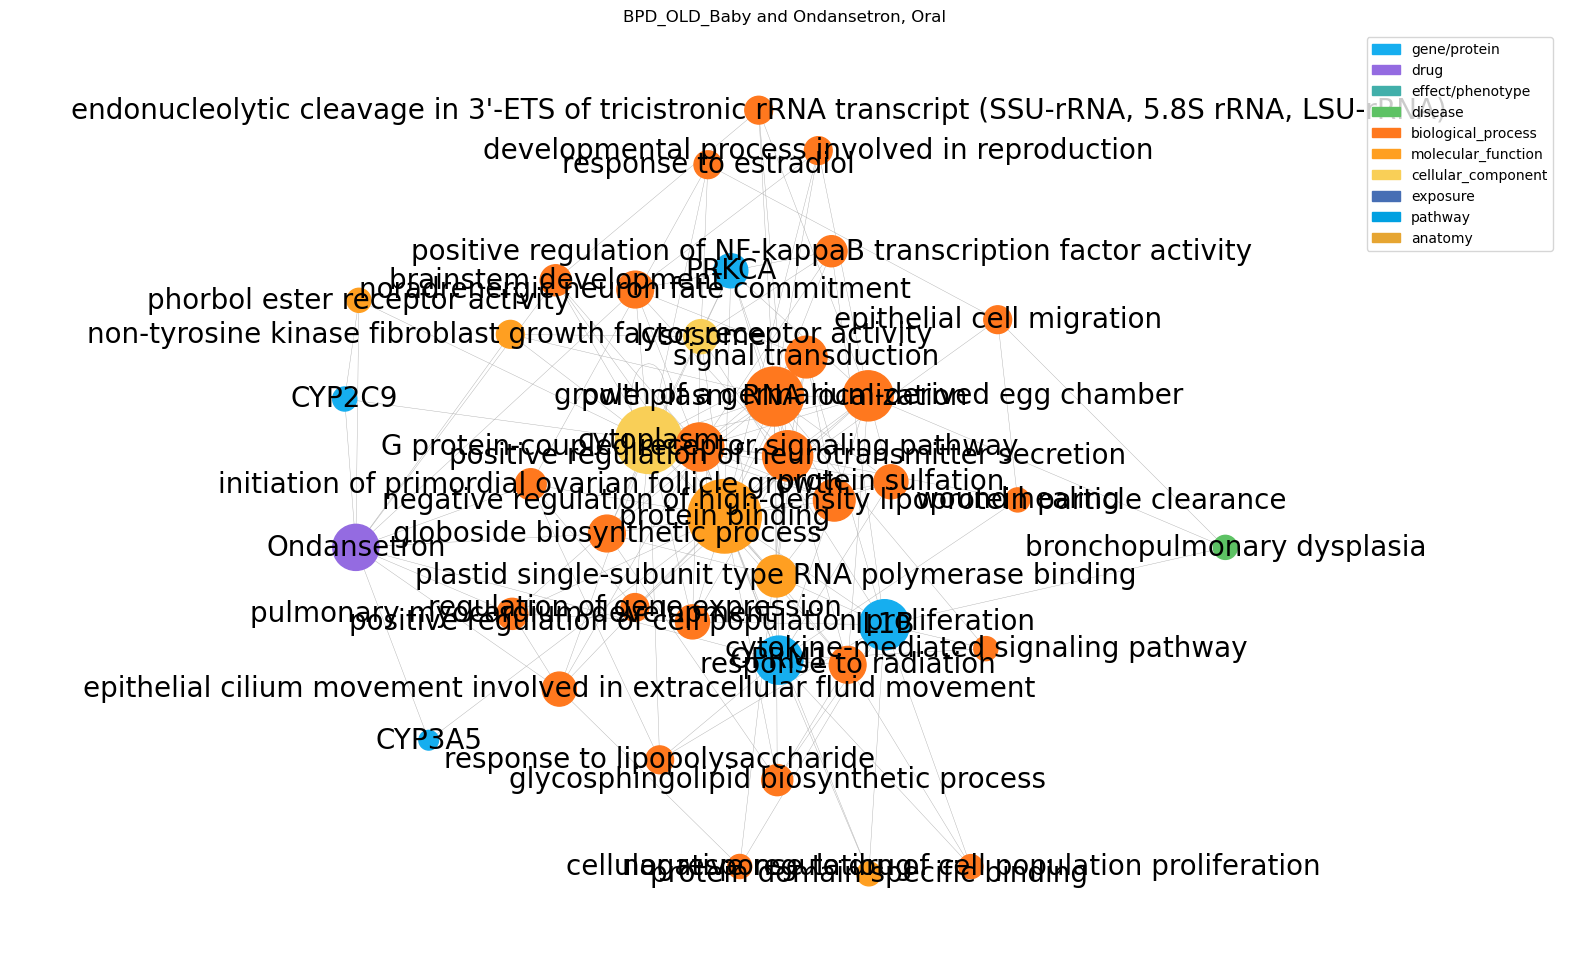

In [9]:
# Generate a shortest path subgraph between Ondansetron and BPD with all biological nodes as intermediary nodes
# The graph is not organized as a circular shape here
T, shortest_paths_dict, num = construct_graph(G,med_id,dz_id_list,dz_name,med_name)
fig = plot_subgraph(T,dz_name,med_name,dz_id_list,med_id,node_color_df)
fig.show()

In [10]:
g = T.copy()

In [11]:
imp_edgest = [('DB00904', '1577'), ('1577', '5515'), ('5515', '3553'), ('3553', '19091')] #['DB00904', '1576', '1051', '3553', '19091']
imp_nodes =['DB00904', '1577', '5515', '3553', '19091']

imp_nodes = list(set(imp_nodes))

imp_labels = {}
labels = nx.get_node_attributes(g, 'node_name')
for node in T.nodes():
    if node in imp_nodes:
        #set the node name as the key and the label as its value 
        imp_labels[node] = labels[node]

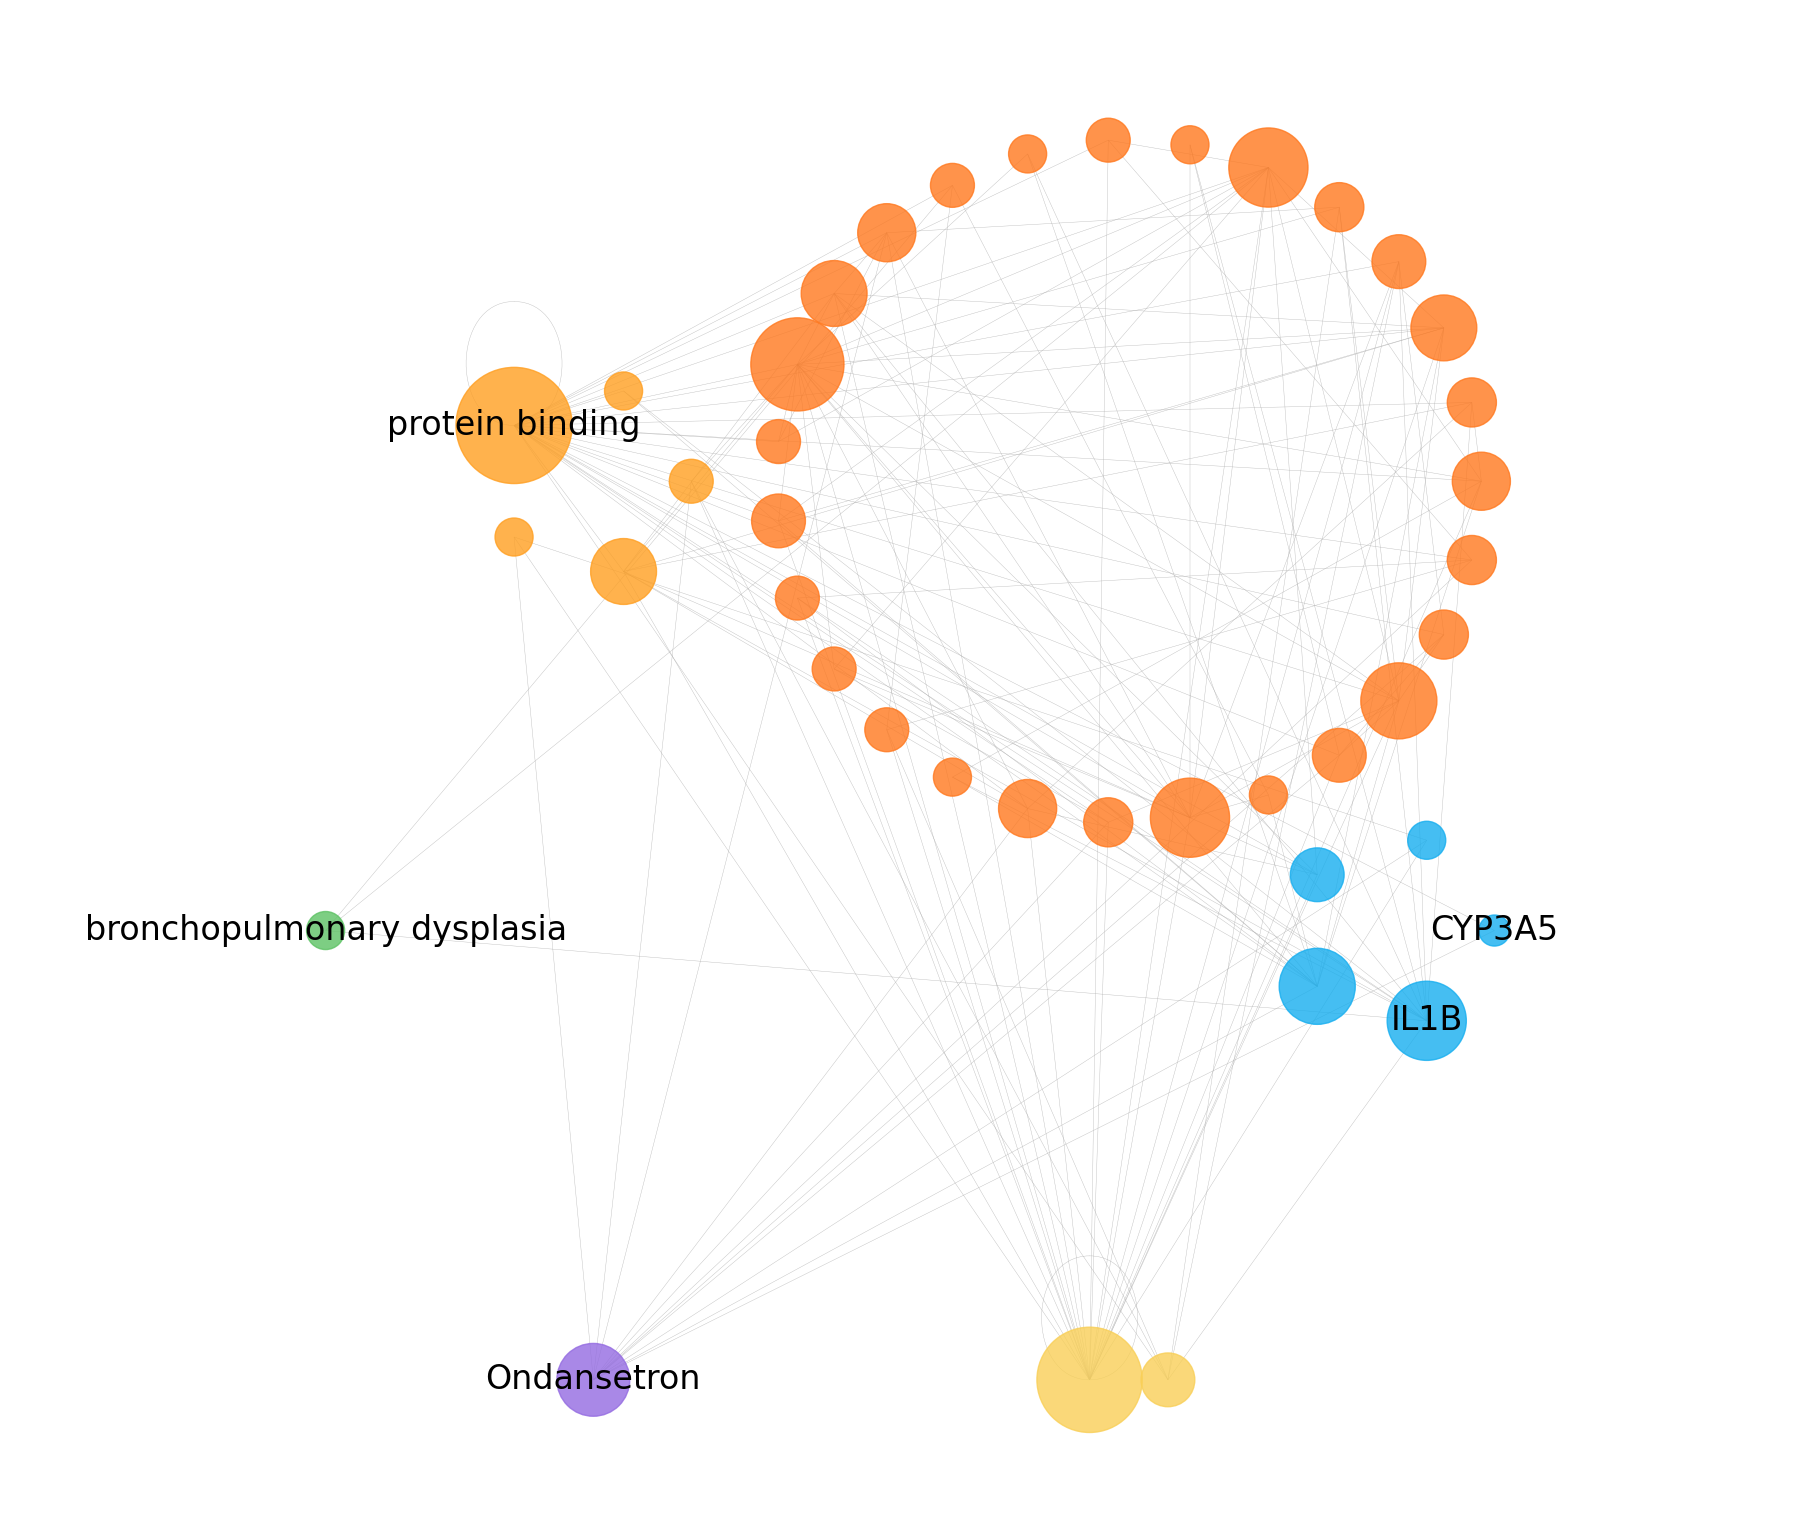

In [12]:
# plotting the shortest paths as circular layout
partition = nx.get_node_attributes(g,'node_type')
pos = community_layout_2(g, partition,14,15)

plt.figure(figsize=(18,15))

labels = nx.get_node_attributes(g, 'node_name')
edge_width = list(nx.get_edge_attributes(g,'weight').values())
edge_colors = list(nx.get_edge_attributes(g,'color').values())
nx.draw(g, pos, node_color=list(nx.get_node_attributes(T,'node_color').values()),edge_color=edge_colors,width=edge_width,labels=labels,with_labels=False,font_size=15,node_size=[g.degree(n)*250 for n in g.nodes()],alpha=0.8)
nx.draw_networkx_labels(g,pos,imp_labels,font_size=24,font_color='#000000')

plt.margins(x=0.2)

plt.show()

In [13]:
# Check the list of all shortest paths
shortest_paths_dict

{0: ['DB00904', '1577', '5515', '3553', '19091'],
 1: ['DB00904', '1544', '5515', '3553', '19091'],
 2: ['DB00904', '1576', '5515', '3553', '19091'],
 3: ['DB00904', '3360', '5515', '3553', '19091'],
 4: ['DB00904', '3350', '5515', '3553', '19091'],
 5: ['DB00904', '3359', '5515', '3553', '19091'],
 6: ['DB00904', '4988', '5515', '3553', '19091'],
 7: ['DB00904', '3351', '5515', '3553', '19091'],
 8: ['DB00904', '1544', '32496', '3553', '19091'],
 9: ['DB00904', '4988', '32496', '3553', '19091'],
 10: ['DB00904', '1576', '1051', '3553', '19091'],
 11: ['DB00904', '1576', '6688', '3553', '19091'],
 12: ['DB00904', '1571', '5764', '3553', '19091'],
 13: ['DB00904', '3350', '8284', '3553', '19091'],
 14: ['DB00904', '3359', '51092', '3553', '19091'],
 15: ['DB00904', '3359', '7165', '3553', '19091'],
 16: ['DB00904', '4988', '19904', '3553', '19091'],
 17: ['DB00904', '4988', '19221', '3553', '19091'],
 18: ['DB00904', '4988', '8285', '3553', '19091'],
 19: ['DB00904', '3351', '35690', '3

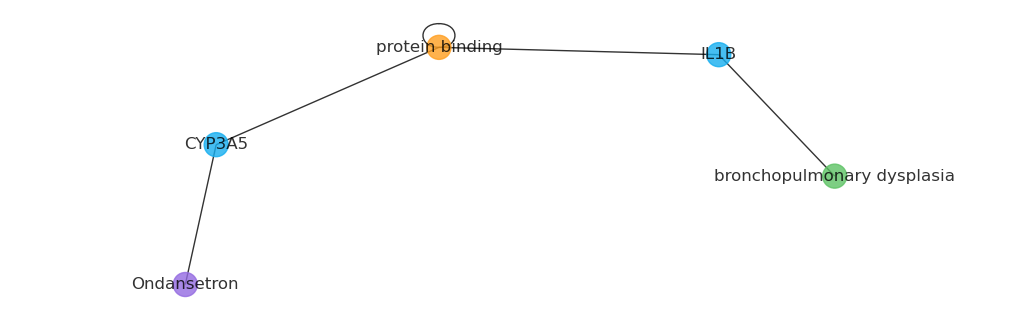

In [14]:
# Check one of the important paths
each_fig = plot_one_shortest_path(G,shortest_paths_dict[0],med_id,dz_id_list)
each_fig.show()